In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import IPython.display as display
import time
import pathlib

from concurrent.futures import ThreadPoolExecutor
from preprocessing import load_image_from_path, image_to_numpy, random_augment_image, central_crop

%matplotlib inline

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
model_dir = pathlib.Path('models')
tflite_model_quant_file = model_dir/'quant_model.tflite'
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter.allocate_tensors()

In [3]:
def get_files(root):
    PATHS = list()

    def parse_dir(root):
        if os.path.isfile(root):
            PATHS.append(root)
        elif os.path.isdir(root):
            for dirname in os.listdir(root):
                parse_dir(os.path.join(root, dirname))

    parse_dir(root)
    return PATHS

PATH_IMAGE = 'icons'

PATHS = get_files(PATH_IMAGE)

In [4]:
def get_labeled_image(path, size):

    def _get_label(path):
        label = tf.strings.split(path, sep=' ')[0]
        label = tf.strings.split(label, sep=os.sep)[-1]
        label = tf.strings.to_number(label, out_type=tf.int32) - 1
        return label

    label = _get_label(path)
    image = load_image_from_path(path.numpy(), target_size=size)

    return (image, label)

def get_data(paths, counts=100, split=False):

    def get_augmented_image(path):
        image, label = get_labeled_image(path, (64, 64))
        image = random_augment_image(image)
        image = image_to_numpy(image) / 255.
        return [image, label]

    images = list()
    labels = list()
    data = list()

    paths = tf.random.shuffle(tf.repeat(paths, counts))
    size = len(paths)

    start_time = time.time()
    
    with ThreadPoolExecutor(32) as pool:
        data = list(pool.map(get_augmented_image, paths))

    for x, y in data:
        images.append(x)
        labels.append(y)

    images = np.array(images)
    labels = np.array(labels)

    tf.print("Loading data takes {:.3f}s".format(time.time()-start_time))

    if split:
        train_size = int(size*0.7)
        return (images[:train_size], labels[:train_size]), (images[train_size:], labels[train_size:])
    else:
        return images, labels

In [5]:
images, labels = get_data(PATHS, counts=20, split=False)

Loading data takes 4.508s


In [22]:
images.shape

(200, 64, 64, 3)

In [6]:
test_image = np.expand_dims(images[10], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

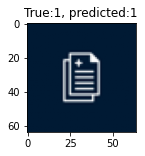

In [9]:
plt.figure(figsize=(2, 2))
plt.imshow(images[10])
template = "True:{true}, predicted:{predict}"
plt.title(template.format(
    true=str(labels[10]+1),
    predict=str(np.argmax(predictions[0])+1)
))
plt.grid(False)
plt.show()

In [31]:
def evaluate_model(interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    # Run predictions on every image in the "test" dataset.
    prediction_digits = []
    for test_image in images:
        # Pre-processing: add batch dimension and convert to float32 to match with
        # the model's input data format.
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)

        # Run inference.
        interpreter.invoke()

        # Post-processing: remove batch dimension and find the digit with highest
        # probability.
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)

    # Compare prediction results with ground truth labels to calculate accuracy.
    accurate_count = 0
    for index in range(len(prediction_digits)):
        if prediction_digits[index] == labels[index]:
            accurate_count += 1
        accuracy = accurate_count * 1.0 / len(prediction_digits)

    return accuracy

In [32]:
test_acc = evaluate_model(interpreter)
print('Test accuracy for quant model is {:.2f}%'.format(test_acc*100))

Test accuracy for quant model is 99.50%


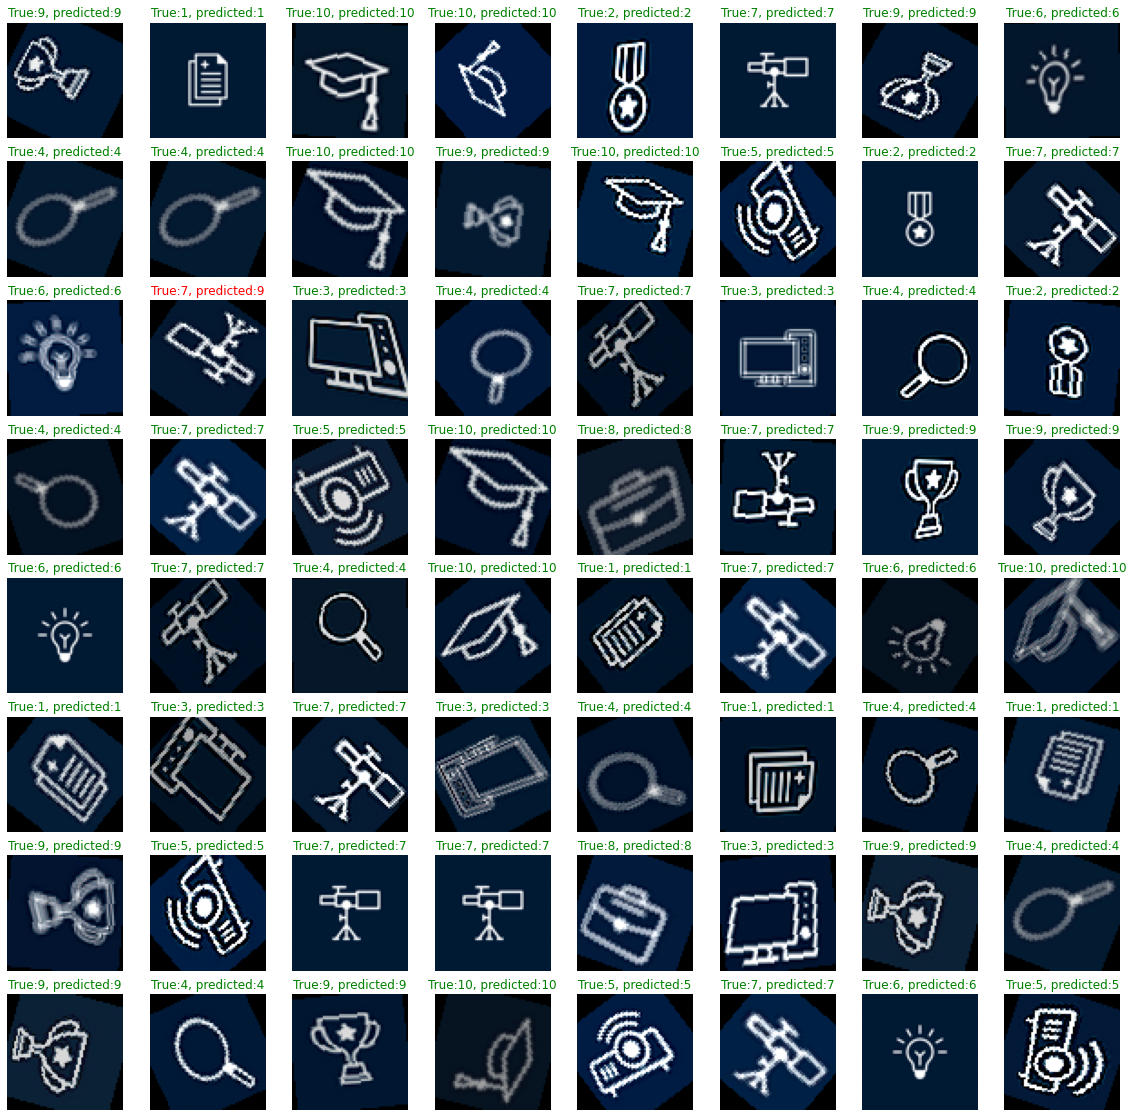

In [13]:
test_indexes = np.random.choice(len(images), 64)

plt.figure(figsize=(20, 20))
for i in range(64):
    img = images[test_indexes[i]]
    true_label = labels[test_indexes[i]]

    test_image = np.expand_dims(img, axis=0).astype(np.float32)
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    interpreter.set_tensor(input_index, test_image)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_index)

    plt.subplot(8, 8, i+1)
    plt.imshow(img)
    color = 'green' if np.argmax(predictions[0]) == true_label else 'red'
    template = "True:{true}, predicted:{predict}"
    plt.title(template.format(
        true=str(true_label+1),
        predict=str(np.argmax(predictions[0])+1)
    ), color=color)
    plt.axis('off')
plt.show()

In [54]:
%%time

with tf.device('CPU'):
    i = 0
    img = images[test_indexes[i]]
    true_label = labels[test_indexes[i]]

    test_image = np.expand_dims(img, axis=0).astype(np.float32)
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    interpreter.set_tensor(input_index, test_image)
    interpreter.invoke()
    predictions = interpreter.get_tensor(output_index)

Wall time: 2 ms


In [38]:
predictions

array([[ -6.677023 ,  13.368602 ,  -8.880495 , -13.955024 ,  -3.3344307,
          5.2484827,   6.759609 , -13.707372 ,  19.564062 ,   2.4255726]],
      dtype=float32)